<h1>LOAN PREDICTION PROBLEM</h1>

Dream Housing Finance company deals in all home loans. They have presence across all urban, semi urban and rural areas. Customer first apply for home loan after that company validates the customer eligibility for loan. Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the customers segments, those are eligible for loan amount so that they can specifically target these customers.

<b>PART I - IMPORTING LIBRARIES</b>

In [2]:
#Import Libraries
import pandas as pd 
import numpy as np #for mathematical calculations
import seaborn as sns  #for data visualization
import matplotlib.pyplot as plt #for plotting graphs
%matplotlib inline 
import warnings   #To ignore warnings
warnings.filterwarnings("ignore")

In [92]:
# The code was removed by Watson Studio for sharing.

In [91]:
#Load Test data set
body = client_1ab4ddc12160403791701f78e1cc1ff5.get_object(Bucket='loanprediction-donotdelete-pr-cnzzsirjewdxp8',Key='test_lAUu6dG.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
df_test = pd.read_csv(body)

<b>PART II - ANALISYS OF THE DATASET</b>

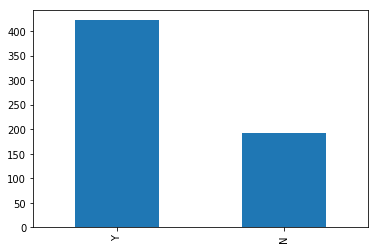

In [16]:
#Dataset Analysis. Train
df_train.dtypes
df_train.shape #(614,13)

#Dataset Analysis. Test
df_test.dtypes
df_test.shape #(367,12)

#Univariate Analysis. For categorical features I use frequency table or bar plots which will calculate the number of each category in a particular variable.
#For numerical features, I use probability density plots to look at the distribution of the variable.
#Target Value
df_train['Loan_Status'].value_counts(normalize=True)
#Plot Bar
df_train['Loan_Status'].value_counts().plot.bar() #Around 69% (422 out of 614) of the loans are granted

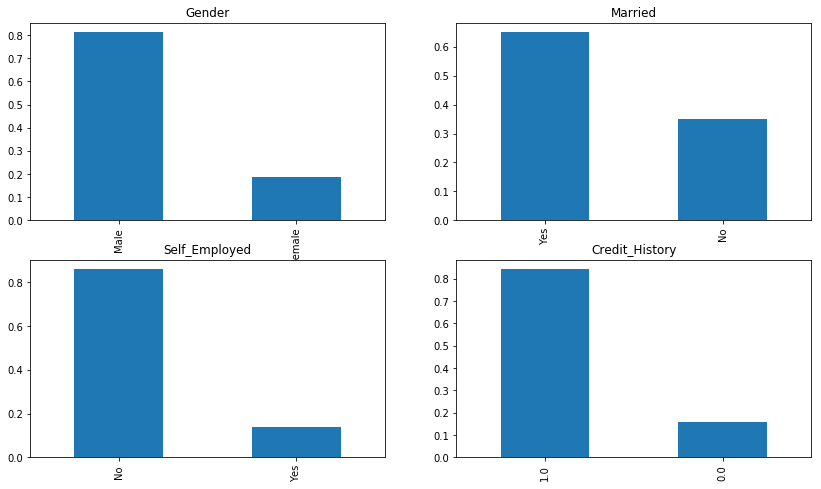

In [43]:
#Univariate Analysis of Categorical Independent Values: Gender, Married, Self_Employed
fig, axarr = plt.subplots(2, 2, figsize=(14, 8))
df_train['Gender'].value_counts(normalize=True).plot.bar(ax=axarr[0][0], title= 'Gender')
df_train['Married'].value_counts(normalize=True).plot.bar(ax=axarr[0][1], title= 'Married')
df_train['Self_Employed'].value_counts(normalize=True).plot.bar(ax=axarr[1][0], title= 'Self_Employed')
df_train['Credit_History'].value_counts(normalize=True).plot.bar(ax=axarr[1][1], title= 'Credit_History')

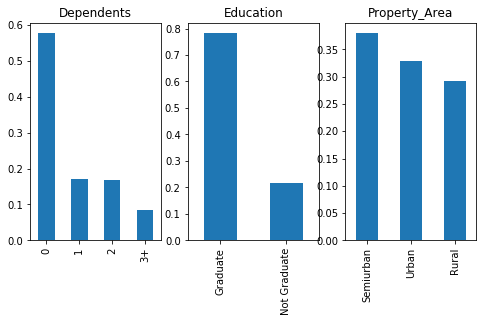

In [50]:
#Univariate Analysis of Ordinal Independent Values: Dependents, Education, Property_Area
fig, axarr = plt.subplots(1, 3, figsize=(8, 4))
df_train['Dependents'].value_counts(normalize=True).plot.bar(ax=axarr[0], title= 'Dependents')
df_train['Education'].value_counts(normalize=True).plot.bar(ax=axarr[1], title= 'Education')
df_train['Property_Area'].value_counts(normalize=True).plot.bar(ax=axarr[2], title= 'Property_Area')

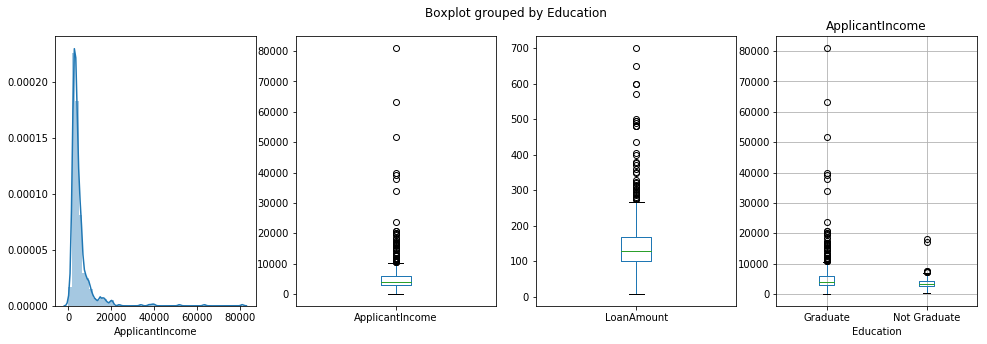

In [89]:
#Univariate Analysis of Numberical Independent Values: ApplicantIncome
fig, axarr = plt.subplots(1, 4, figsize=(8, 4))
sns.distplot(df_train['ApplicantIncome'],ax=axarr[0])
df_train['ApplicantIncome'].plot.box(figsize=(16,5),ax=axarr[1])
df_train['LoanAmount'].plot.box(figsize=(16,5),ax=axarr[2])
df_train.boxplot(column='ApplicantIncome', by = 'Education',ax=axarr[3])